# Remote Sensing of Riparian Buffer Ecological Effects
---
## Abstract
Riparian Buffer Systems refer to vegetation growing along rivers which fulfill an important ecological role:  they filter non-point source pollution such as fertilizer containing farm runoff and help prevent undesirable ecological effects downstream.  Such effects include algal blooms and creation of dead zones in oceans and lakes, adversely effecting animal and human life as well as local economies which depend on fishing and tourism.  This notebook demonstrates how to perform GIS-based analyses using Open Data Cube to investigate such systems.  Specifically, this notebook presents several methods of integrating non-GIS and GIS data (laboratory based chemical analyses of water, as well as GIS based sensing of vegetation and Total Suspended Matter) by using the Elizabeth River in Virginia and the Chesapeake Bay as an example.  This notebook also presents and demonstrates an algorithm for identifying riparian zones and calculating NDVI indexes for them. 


## [Index](#Index)
* [Introduction](#Introduction-%E2%96%B4)
* [Background](#)
    * [History](#History)
    * [Riparian Buffer Zones](#Riparian-Buffer-Zones)
* [Configuration and Dependencies](#Configuration-and-Dependencies-%E2%96%B4)
* [Water Quality Monitoring Stations](#-Water-Quality-Monitoring-Stations-%E2%96%B4)
    * [Map of All Available Stations](#Map-of-All-Available-Stations)
    * [Elizabeth River Stations](#Elizabeth-River-Stations)
* [Water Quality Data](#Water-Quality-Data-%E2%96%B4)
    * [Optical Density Data](#Optical-Density-Data-%E2%96%B4)
* [Landsat 8 Data](#Landsat-8-Data-%E2%96%B4)
    * [Total Suspended Matter (TSM)](#Total-Suspended-Matter-(TSM))
    * [Mean Total Suspended Matter (TSM) Per Pixel](#Mean-Total-Suspended-Matter-(TSM)-Per-Pixel)
    * [Maximum Total Suspended Matter (TSM) Per Pixel](#Maximum-Total-Suspended-Matter-(TSM)-Per-Pixel)
    * [Normalized Difference Vegetation Index (NDVI)](#Normalized-Difference-Vegetation-Index-(NDVI))
    * [Paradise Creek Restoration](#Paradise-Creek-Restoration)
* [Data Correlation Matrix](#Data-Correlation-Matrix-%E2%96%B4)
    * [List of Strong Correlations](#List-of-Strong-Correlations)
* [Data Plots](#Data-Plots-%E2%96%B4)
    * [Dissolved Oxygen and Phosphates](#Dissolved-Oxygen-and-Phosphates)
    * [Temperature](#Temperature)
    * [Filtered Nitrates, Total Dissolved Phosphorus, and Total Suspended Solids](#Filtered-Nitrates,-Total-Dissolved-Phosphorus,-and-Total-Suspended-Solids)
    * [Optical Density](#Optical-Density)
* [Conclusion and Future Work](#Conclusion-and-Future-Work-%E2%96%B4)
* [References](#References-%E2%96%B4)
    
---
![riparian Image](imgs/buffer_image.png)  Image from (Cunningham, Stuhlinger, and Liechty, n.d.) [1]

## [Introduction &#9652;](#Index)
The goal of this notebook is to explore novel methods for remotely evaluating riparian buffer zones and assessing their ecological effects on water quality. The hope is to use the capabilities of the Open Data Cube platform in combination with water quality data to quantitatively examine links between environmental pollution, riparian vegetation, and water quality in the Chesapeake Bay. This notebook will also serve as a technological demonstration fusing data from both GIS and non-GIS data sources.

## [Background &#9652;](#Index)
The Chesapeake Bay is the largest estuary in the United States and is the defining feature of the Virginia coast. As such, the health of its ecosystems is of concern to all Virginians. This notebook also focuses on the Bay and watershed as a case study because of its locality, history of restoration projects, and water quality monitoring.

### History
In the late 1970s and early 1980s, under the leadership of Sen. Charles Mathias, Congress initiated studies into the rapid loss of both aquatic and wildlife in the Chesapeake Bay watershed. These studies drew attention to the bays declining water quality and identified three areas of immediate concern:
- toxic pollutant levels
- the decline of bay grasses 
- nutrient over enrichment

The findings led to support for the adoption of The Chesapeake Bay Agreement of 1983 which established the Chesapeake Executive Counsel which formed the Chesapeake Bay Program Executive Council. Two further agreements, The 1987 Chesapeake Bay Agreement and Chesapeake 2000, were later signed adding more partners, setting quantitative goals for the Bay ecosystem, and setting out guides for restoration efforts. Part of these efforts have focused on restoring riparian buffer zones to control non-point sources of pollution.


### Riparian Buffer Zones
Riparian buffers are areas of vegetation composed of grasses, shrubs, or forest in transition zones between land and water. Buffers are important for slowing runoff and enhancing water infiltration. By slowing runoff and trapping sediment, buffers minimize the opportunities for pollutants to contaminate surface or groundwater. Riparian buffers are conceptualized in three zones each with distinct functions.
![Buffer zones](imgs/buffer_zones.png)(Cunningham, Stuhlinger, and Liechty, n.d.) [1]

These zones are important in both agrarian and suburban settings, the core being the riparian forrest zone.

![Examples](imgs/buffer_examples.png)(Cunningham, Stuhlinger, and Liechty, n.d.) [1]

Riparian Buffer zones serve three primary functions in improving water quality:
1. Converting Surface flow to Subsurface flow
2. Absorbing Nitrogen and Phosphorous Nutrients
3. Retaining Sediment

![Hydrogeomorphic Regions](imgs/hydrogeomorphic_regions.png)(Lowrance et al. 1997) [2]

The immediate Chesapeake Bay Area consists primarily of two hydrogeomorphic zones: the Inner Coastal Plain on the western shore and Poorly Drained Upland on the Delmarva Peninsula. 

<img src = "imgs/inner_coastal_plain.png" width="600"/>

<img src = "imgs/poorly_drained.png" width="1000"/>
    
(Lowrance et al. 1997) [2]

## [Configuration and Dependencies &#9652;](#Index)
Before we attemnpt to analyze any data, we must first setup our programming enviroment by importing any Python libraries we may need for our analysis. Below we add the folium library, which we will use to display maps in the notebook, as well as the numpy, xarray, and pandas libraries which we will use to manipulate our data. The seaborn and matplotlib libraries are used to plot and graphicaly display our results.

In [3]:
import sys
sys.path.append("..") #Required to use Data Cube utilities

import warnings

import folium
import folium.plugins
import numpy as np
import xarray as xr
import pandas as pd
pd.options.display.max_columns = None

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "axes.grid": True,
    "lines.linewidth": 2,
}
pylab.rcParams.update(params)

import utils.data_cube_utilities.data_access_api as dc_api
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.dc_water_quality import tsm
from utils.data_cube_utilities.plotter_utils import figure_ratio
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
from utils.data_cube_utilities.vegetation import NDVI
api = dc_api.DataAccessApi()
dc = api.dc

## [ Water Quality Monitoring Stations &#9652;](#Index)
---
In order to explore what potential water quality information can be gleaned from Landsat imagery, a source of ground truth data is needed. Water quality measurements were obtained from the Chesapeake Bay Program via the [Chesapeake Bay Data Hub](http://data.chesapeakebay.net). Although not all collections feature all water quality tests and parameters, the data has an extensive history generally stretching back to 1984.

The subset of required data was downloaded from the Chesapeake Bay Data Hub and converted to a parquet format to make it a managable size. The parquet format is a free and open-source format maintianed as part of the Apache project. In order to manipulate the data we must first read it into a Pandas dataframe. Conveniently, we can use the built in read_parquet Pandas method as long as the fastparquet or pyarrow libary dependency is satisfied. In the data set all data collection sites are referred to as "stations".

In [4]:
data = pd.read_parquet("data/water_quality.pq.gzip")
data_stations = list(set(data["station"]))
data_stations.sort()
stations = pd.read_parquet("data/stations.pq.gzip").loc[data_stations]
#stations

### Map of All Available Stations
Below we create a map using the Folium python library to display all the stations available in the subset of data downloaded from the Chesapeake Bay Data Hub. We instantiate the map with an initial location over the Chesapeake Bay and at an appropriate zoom level. We then add a layer of satellite imagery and then iterate over the dataset adding a marker at the location for each station. Finally, a few user comforts are added to the map, such as mini-map and full screen viewing. 

In [5]:
m = folium.Map(location=[39, -78], zoom_start=7,tiles = 'Stamen Terrain')
folium.raster_layers.WmsTileLayer(
    url = 'http://services.arcgisonline.com/arcgis/rest/services/World_Imagery' + '/MapServer/tile/{z}/{y}/{x}',
    layers = None,
    name = 'Esri WorldImagery',
    attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community').add_to(m)
for i, s in stations.iterrows():
    if not np.isnan(s.Latitude):
        folium.Circle([s.Latitude, s.Longitude],radius = 100, color='red', fill_color='red', popup=i, tooltip=s.Description, fill =True).add_to(m)
mini = folium.plugins.MiniMap(toggle_display = True)
m.add_child(mini)
folium.plugins.ScrollZoomToggler().add_to(m)
folium.plugins.Fullscreen(position='topright').add_to(m)
folium.LayerControl().add_to(m)
m

### Elizabeth River Stations 
Below we select a subset of stations which are in an area of interest on the Elizabeth River. Although the Elizabeth River has a relatively small watershed, it has been one of the most stressed areas of the Chesapeake Bay.  The Elizabeth River Project describes the river as long being infamous for its levels of pollution. The river faces many challenges as much of the shoreline is dominated by the urban and suburban areas of Norfolk and Portsmouth. 

In [6]:
loc = [36.83, -76.33]
eliz_stations = stations[(abs(stations.Latitude - loc[0]) < 0.1) & (abs(stations.Longitude - loc[1]) < 0.12)]
main_stations = [1240, 1241, 1243, 1341]
ne_stations = [1342, 1343]
east_stations = [1225, 1226]
west_stations = [1671, 1672]
south_stations = [1521, 1524]

#### Map of Stations of Interest
We proceed to map the station locations to get a better idea of their distribution and of the surrounding area from which the water quality is being sampled.

In [7]:
eliz_map = folium.Map(location=loc, zoom_start=12, tiles = "Stamen Terrain" )
folium.raster_layers.WmsTileLayer(
    url = 'http://services.arcgisonline.com/arcgis/rest/services/World_Imagery' + '/MapServer/tile/{z}/{y}/{x}',
    layers = None,
    name = 'Esri WorldImagery',
    attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community').add_to(eliz_map)
folium.Marker([eliz_stations.loc[1240].Latitude, eliz_stations.loc[1240].Longitude], tooltip=folium.Tooltip(
    "Main Body", permanent=True, direction="right", offset=(30, -10))).add_to(eliz_map)
folium.Marker([eliz_stations.loc[1343].Latitude, eliz_stations.loc[1343].Longitude], tooltip=folium.Tooltip(
    "Northeast Branch", permanent=True, direction="right", offset=(30, -10))).add_to(eliz_map)
folium.Marker([eliz_stations.loc[1225].Latitude, eliz_stations.loc[1225].Longitude], tooltip=folium.Tooltip(
    "East Branch", permanent=True, direction="top", offset=(60, -10))).add_to(eliz_map)
folium.Marker([eliz_stations.loc[1671].Latitude, eliz_stations.loc[1671].Longitude], tooltip=folium.Tooltip(
    "West Branch", permanent=True, direction="top", offset=(50, -40))).add_to(eliz_map)
folium.Marker([eliz_stations.loc[1517].Latitude, eliz_stations.loc[1517].Longitude], tooltip=folium.Tooltip(
    "South Branch", permanent=True, direction="right", offset=(10, 0))).add_to(eliz_map)
for i, s in eliz_stations.iterrows():
    if not np.isnan(s.Latitude):
        folium.Marker([s.Latitude, s.Longitude], popup=i, tooltip=s.Description).add_to(eliz_map)
folium.plugins.ScrollZoomToggler().add_to(eliz_map)
folium.plugins.Fullscreen(position='topright').add_to(eliz_map)
folium.LayerControl().add_to(eliz_map)
eliz_map.add_child(folium.plugins.MiniMap(toggle_display = True))
eliz_map

# [Water Quality Data &#9652;](#Index)
---
For this analysis, available water quality and optical density data from all monitoring stations from 2000 till present was imported. Of notable interest are the nitrogen and phosophorous parameters as they are of most concern for nutrient over enrichment.

Below, all available water quality parameters are listed.

*Note: not all monitoring events (times) include all variables.*

In [8]:
descrip = pd.read_parquet("data/water_quality_description.pq.gzip")
descrip

units                                        description
variable                                                                
T                  °C                                  water temperature
Ph                                   Ph corrected for temperature (25°C)
salinity      PPT|PSU                                           salinity
alkalinity       mg/L                          total alkalinity as CACO3
k             μmho/cm  conductivity corrected for temperature (25°C) ...
m_dot             CFS                          flow rate (instantaneous)
m_dot_avg         CFS                          flow rate (daily average)
turbidity         NTU                   turbidity (nephelometric method)
attenuation       1/m                      light attenuation coefficient
Secchi_depth        m                                       Secchi depth
FSS              mg/L                             fixed suspended solids
VSS              mg/L                          volatile suspended solids
TDS              mg/L               total dissolved solids (gravimetric)
TSS              mg/L                             total suspended solids
SSC_fine         mg/L            suspended sediment particles < 0.062 mm
SSC_sand         mg/L           suspended sediment particles >= 0.062 mm
SSC              mg/L             total suspended sediment concentration
chlorophyll      mg/L                               active chlorophyll-A
pheophytin       mg/L                                         pheophytin
TOC              mg/L                               total organic carbon
PC               mg/L                                 particulate carbon
PIC              mg/L                       particulate inorganic carbon
POC              mg/L                         particulate organic carbon
DOC              mg/L                           dissolved organic carbon
DO               mg/L                                   dissolved oxygen
TN               mg/L                                     total nitrogen
TON              mg/L                             total organic nitrogen
TDN              mg/L                           total dissolved nitrogen
PN               mg/L                               particulate nitrogen
PON              mg/L                       particulate organic nitrogen
DIN              mg/L                       dissolved inorganic nitrogen
DON              mg/L                         dissolved organic nitrogen
NH4              mg/L                         ammonium (filtered sample)
NO2              mg/L                          nitrite (filtered sample)
NO3              mg/L                          nitrate (filtered sample)
TP               mg/L                                   total phosphorus
TDP              mg/L                         total dissolved phosphorus
PP               mg/L                             particulate phosphorus
PIP              mg/L                   particulate inorganic phosphorus
DOP              mg/L                       dissolved organic phosphorus
PO4              mg/L                   orthophosphate (filtered sample)
Si               mg/L                           silica (filtered sample)

In [9]:
eliz_data = data[data["station"].isin(eliz_stations.index)].drop(
    columns=["PON", "TOC", "POC", "PIP", "PIC", "SSC_sand", "alkalinity", "TDS", "SCC", "m_dot", "m_dot_avg", "SSC_fine"])
eliz_data[eliz_data.columns.difference(["station", "lat", "lon", "depth"])].describe().sort_values(
    by="count", ascending=False, axis=1)

k             T      salinity            DO            Ph  \
count   18661.000000  18317.000000  18315.000000  18210.000000  18129.000000   
mean    30704.491599     17.549334     19.007672      7.538500      7.642545   
std      5666.483730      7.789470      3.341529      2.500709      0.304569   
min       949.000000      1.000000      0.470000      0.210000      4.620000   
25%     27701.000000     10.320000     16.920000      5.590000      7.460000   
50%     31218.000000     18.060000     19.350000      7.310000      7.660000   
75%     34190.000000     25.000000     21.400000      9.340000      7.830000   
max    304819.000000     35.980000     30.600000     16.170000      8.900000   

               TSS          TDN          PO4           PC           PP  \
count  5535.000000  5531.000000  5527.000000  5516.000000  5514.000000   
mean     17.438346     0.506731     0.029754     1.106515     0.032676   
std      14.187944     0.250808     0.027242     1.145196     0.026000   
min       1.000000     0.092000     0.000200     0.050000     0.001300   
25%       8.000000     0.331000     0.007000     0.529000     0.017300   
50%      12.800000     0.450000     0.022200     0.828620     0.026630   
75%      22.857145     0.624000     0.045400     1.330000     0.039400   
max     141.000000     4.648000     0.199800    29.600000     0.534000   

               TDP           PN          NH4          DOP          DON  \
count  5512.000000  5482.000000  5419.000000  5372.000000  5350.000000   
mean      0.037548     0.171792     0.095225     0.007850     0.295913   
std       0.030216     0.167328     0.102218     0.008948     0.107188   
min       0.000900     0.010000     0.000500    -0.010300    -0.012000   
25%       0.014000     0.077480     0.020000     0.003000     0.237000   
50%       0.030000     0.131000     0.068000     0.006000     0.275000   
75%       0.054000     0.213000     0.133800     0.010200     0.325000   
max       0.262000     4.370000     1.320900     0.145000     1.940000   

               DIN          FSS           TP           TN          TON  \
count  5348.000000  5101.000000  4927.000000  4316.000000  4284.000000   
mean      0.216695    12.924222     0.072925     0.714162     0.489155   
std       0.187337    11.387180     0.042628     0.284610     0.219695   
min       0.000700     1.000000     0.004700     0.259000     0.056600   
25%       0.074000     5.000000     0.045100     0.540000     0.368000   
50%       0.186950     9.000000     0.061100     0.661000     0.442500   
75%       0.319000    17.000000     0.088750     0.816000     0.552100   
max       2.708000    92.000000     0.735000     5.106000     5.073000   

               NO2    turbidity          NO3  chlorophyll   pheophytin  \
count  4071.000000  4022.000000  3820.000000  3479.000000  3479.000000   
mean      0.026066     8.577812     0.074603     0.010814     0.002280   
std       0.052519     7.234962     0.083614     0.016820     0.002780   
min       0.002000     0.080000    -0.002000     0.000100     0.000100   
25%       0.002000     3.800000     0.011000     0.003400     0.000668   
50%       0.005000     6.185000     0.049000     0.006942     0.001442   
75%       0.016000    10.900000     0.114000     0.013529     0.002990   
max       0.392000    61.200000     1.201100     0.389460     0.056900   

       Secchi_depth          VSS           Si  attenuation         DOC  
count   2717.000000  1512.000000  1482.000000  1268.000000  129.000000  
mean       1.006367     6.295179     1.042412     1.953432   10.341023  
std        0.494308     6.268473     0.651016     0.959889    6.713818  
min        0.200000    -0.330000     0.050000     0.096500    3.100000  
25%        0.700000     3.000000     0.560000     1.299600    5.443000  
50%        0.900000     5.000000     0.980000     1.787100    8.720000  
75%        1.200000     8.000000     1.495300     2.338350   13.400000  
max        5.200000   100.000000     3.790000 

## [Optical Density Data &#9652;](#Index)
Optical density data is of interest as it provides us with an indication of how photosynthetically active radiation will interact with the water column and influence biological activity of the aquatic ecosystem. The data is presented in units of  photon flux per square meter. 

In [10]:
od_descrip = pd.read_parquet("data/optical_density_description.pq.gzip")
od_descrip

units              description
variable                                      
V_extract           L           extract volume
V_sample            L            sample volume
light_path         cm               light path
od_630b     μmol/m2/s  optical density (630nm)
od_645b     μmol/m2/s  optical density (645nm)
od_647b     μmol/m2/s  optical density (647nm)
od_663b     μmol/m2/s  optical density (663nm)
od_664b     μmol/m2/s  optical density (664nm)
od_665a     μmol/m2/s  optical density (665nm)
od_750a     μmol/m2/s  optical density (750nm)
od_750b     μmol/m2/s  optical density (750nm)

In [11]:
od_data = pd.read_parquet("data/optical_density.pq.gzip")
eliz_od_data = od_data[od_data["station"].isin(eliz_stations.index)]
eliz_od_data[eliz_od_data.columns.difference(["station", "lat", "lon", "depth"])].describe().sort_values(
    by="count", ascending=False, axis=1)

V_extract     V_sample   light_path      od_630b      od_664b  \
count  2507.000000  2507.000000  2507.000000  2507.000000  2507.000000   
mean      0.010030     0.317188     4.930594     0.043229     0.164434   
std       0.000347     0.055611     0.503746     0.041385     0.144003   
min       0.010000     0.050000     1.000000     0.001000     0.001000   
25%       0.010000     0.300000     5.000000     0.017000     0.066000   
50%       0.010000     0.300000     5.000000     0.031000     0.122000   
75%       0.010000     0.300000     5.000000     0.056000     0.217000   
max       0.014000     0.700000     5.000000     0.519000     1.325000   

           od_665a      od_750a      od_750b      od_647b    od_645b  \
count  2507.000000  2507.000000  2507.000000  2506.000000  57.000000   
mean      0.108456     0.007026     0.005004     0.050056   0.027754   
std       0.089897     0.003312     0.003739     0.041627   0.028302   
min       0.002000    -0.007000    -0.002000     0.001000   0.002000   
25%       0.046000     0.006000     0.004000     0.022000   0.011000   
50%       0.083000     0.007000     0.005000     0.038000   0.018000   
75%       0.143500     0.008000     0.006000     0.065000   0.037000   
max       0.799000     0.099000     0.131000     0.378000   0.168000   

         od_663b  
count  57.000000  
mean    0.103649  
std     0.109967  
min     0.008000  
25%     0.036000  
50%     0.063000  
75%     0.126000  
max     0.631000

# [Landsat 8 Data &#9652;](#Index)
---
The Landsat 8 is an earth observation satellite administered jointly by NASA and the USGS. Launched in 2013, it has both visible and infrared sensors with resolution ranging from 15 to 100 meters. In this section, we use multispectral images taken by Landst 8 to compute the Total Suspended Matter and Normalized Difference Vegetation Index around the Elizabeth River.

In [12]:
lat = (36.9664, 36.7218)
lon = (-76.4351, -76.1591)
time = ("2013-01-01", "2020-12-31")
measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
ls8_data = dc.load(platform="LANDSAT_8", product="ls8_lasrc_va3414", 
                   lat=lat, lon=lon, time=time, measurements=measurements)
ls8_data = ls8_data.where(landsat_qa_clean_mask(ls8_data, "LANDSAT_8")).astype('int16')

# Divide the river into branches
western_branch = dict(latitude=slice(36.8700, 36.7866), longitude=slice(-76.9500, -76.3376))
southern_branch = dict(latitude=slice(36.8424, 36.7), longitude=slice(-76.3650, -76.2375))
eastern_branch = dict(latitude=slice(36.88, 36.8), longitude=slice(-76.29, -76.15))
main_body = dict(latitude=slice(36.9658, 36.8380), longitude=slice(-76.3665, -76.295))

### Total Suspended Matter (TSM)

Total suspended matter is a measure of the amount of solid particulate mater suspended in the water. This measurement is calculated by comparing the reflectance in several select bands which change as more particulate matter becomes suspended. 

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    water_mask = wofs_classify(ls8_data, no_data=0.0).wofs.astype(np.bool)
water_data = ls8_data.where(water_mask).astype("int16")

In [14]:
tsm_data = tsm(water_data)
main_tsm = tsm_data.sel(main_body)
east_tsm = tsm_data.sel(eastern_branch)
south_tsm = tsm_data.sel(southern_branch)
west_tsm = tsm_data.sel(western_branch)

### Mean Total Suspended Matter (TSM) Per Pixel
Here the mean TSM for each pixel is calulated for the observation time.

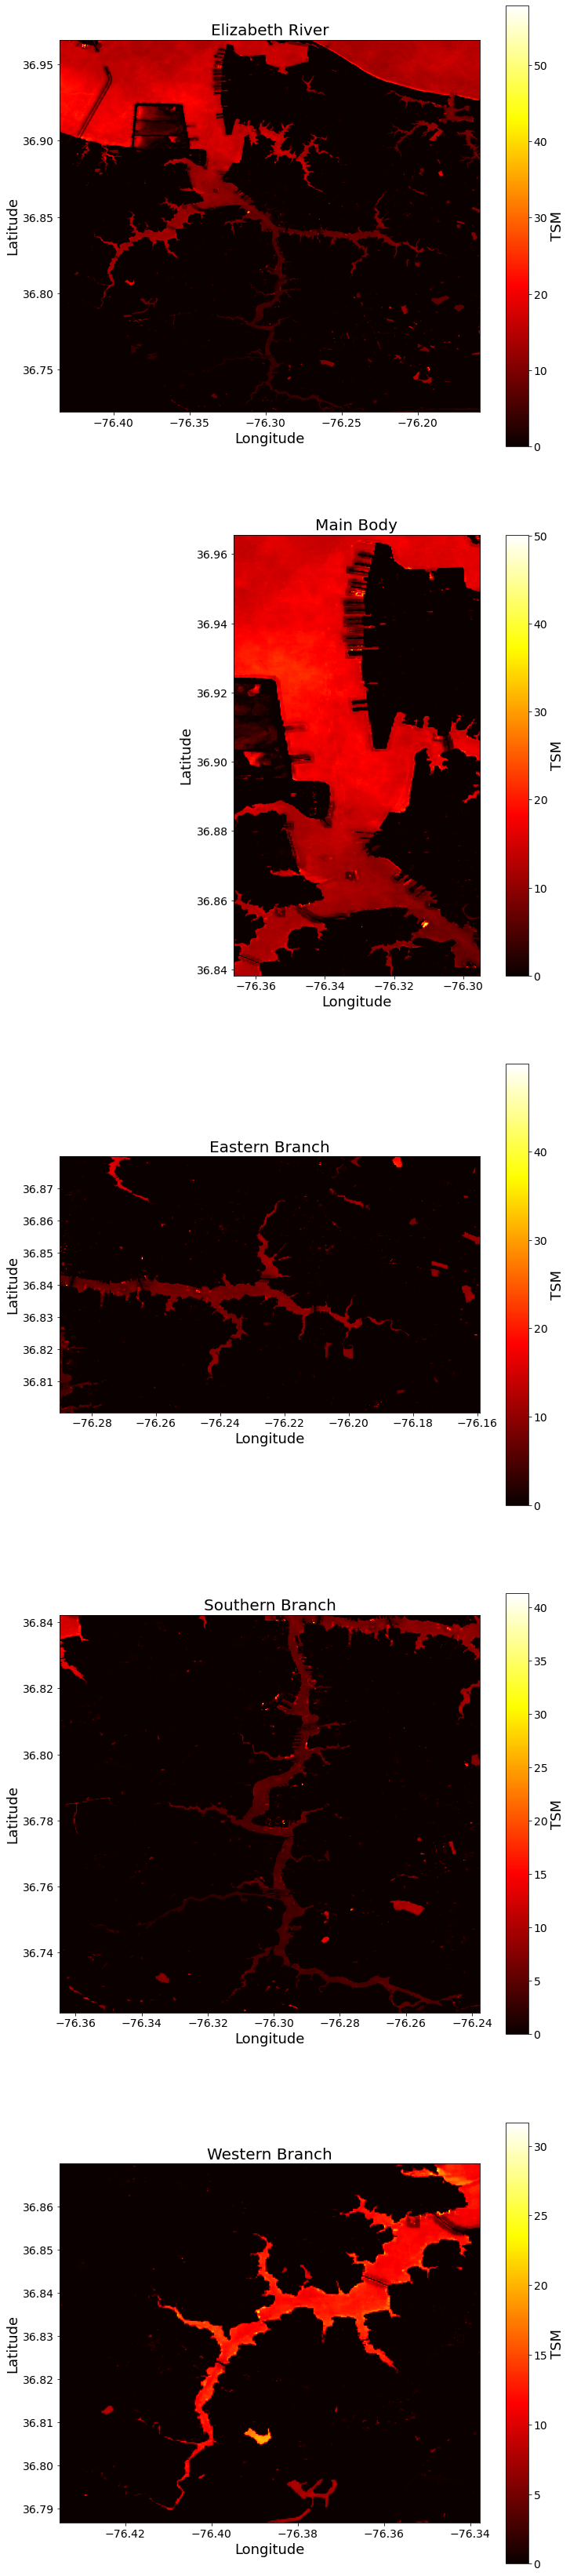

In [15]:
mean_tsm_per_pixel = tsm_data.mean(dim=["time"]).fillna(0)
main_body_per_pixel_mean = main_tsm.mean(dim=["time"]).fillna(0)
east_branch_per_pixel_mean = east_tsm.mean(dim=["time"]).fillna(0)
south_branch_per_pixel_mean = south_tsm.mean(dim=["time"]).fillna(0)
west_branch_per_pixel_mean = west_tsm.mean(dim=["time"]).fillna(0)

fig, axes = plt.subplots(nrows=5, figsize=(12, 60))

river_sections = [mean_tsm_per_pixel, 
                  main_body_per_pixel_mean, 
                  east_branch_per_pixel_mean, 
                  south_branch_per_pixel_mean, 
                  west_branch_per_pixel_mean]

titles = ['Elizabeth River',
          'Main Body',
          'Eastern Branch',
          'Southern Branch',
          'Western Branch']

for i, river_section in enumerate(river_sections):
    extent = [river_section.longitude.min(),
          river_section.longitude.max(),
          river_section.latitude.min(),
          river_section.latitude.max()]
    im = axes[i].imshow(river_section.tsm, cmap='hot', extent=extent)
    axes[i].grid(False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    tsm_scale = fig.colorbar(im, ax=axes[i])
    tsm_scale.set_label('TSM')

The plot below shows the mean TSM for each section of the Elizabeth River per month between 2013 and 2020.

The monthly mean was obtained by downsampling the original ~16 day data from Landsat to 1 month data. This is done to match the sample rate of the remaining water quality data.

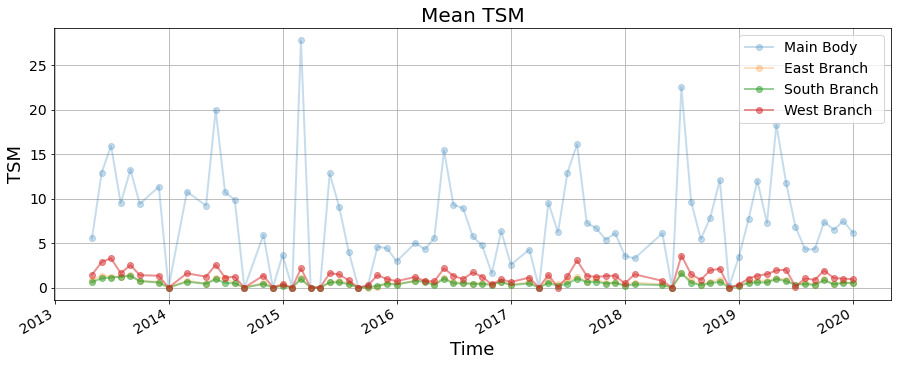

In [16]:
main_body_monthly_mean_tsm = main_tsm.mean(dim=['latitude', 'longitude']).resample(time="1M").mean().dropna(dim='time')
east_monthly_mean_tsm = east_tsm.mean(dim=['latitude', 'longitude']).resample(time="1M").mean().dropna(dim='time')
south_monthly_mean_tsm = south_tsm.mean(dim=['latitude', 'longitude']).resample(time="1M").mean().dropna(dim='time')
west_monthly_mean_tsm = west_tsm.mean(dim=['latitude', 'longitude']).resample(time="1M").mean().dropna(dim='time')

fig, ax = plt.subplots(nrows=1, figsize=(15, 5))

main_body_monthly_mean_tsm.tsm.plot(ax=ax, marker="o", alpha=0.25, label="Main Body")
east_monthly_mean_tsm.tsm.plot(ax=ax, marker="o", alpha=0.25, label="East Branch")
south_monthly_mean_tsm.tsm.plot(ax=ax, marker="o", alpha=0.5, label="South Branch")
west_monthly_mean_tsm.tsm.plot(ax=ax, marker="o", alpha=0.5, label="West Branch")
ax.legend()

plt.title('Mean TSM')
plt.xlabel('Time')
plt.ylabel('TSM')
plt.show()

### Maximum Total Suspended Matter (TSM) Per Pixel
Below, the maximum TSM value for each individual pixel across the dataset is displayed.

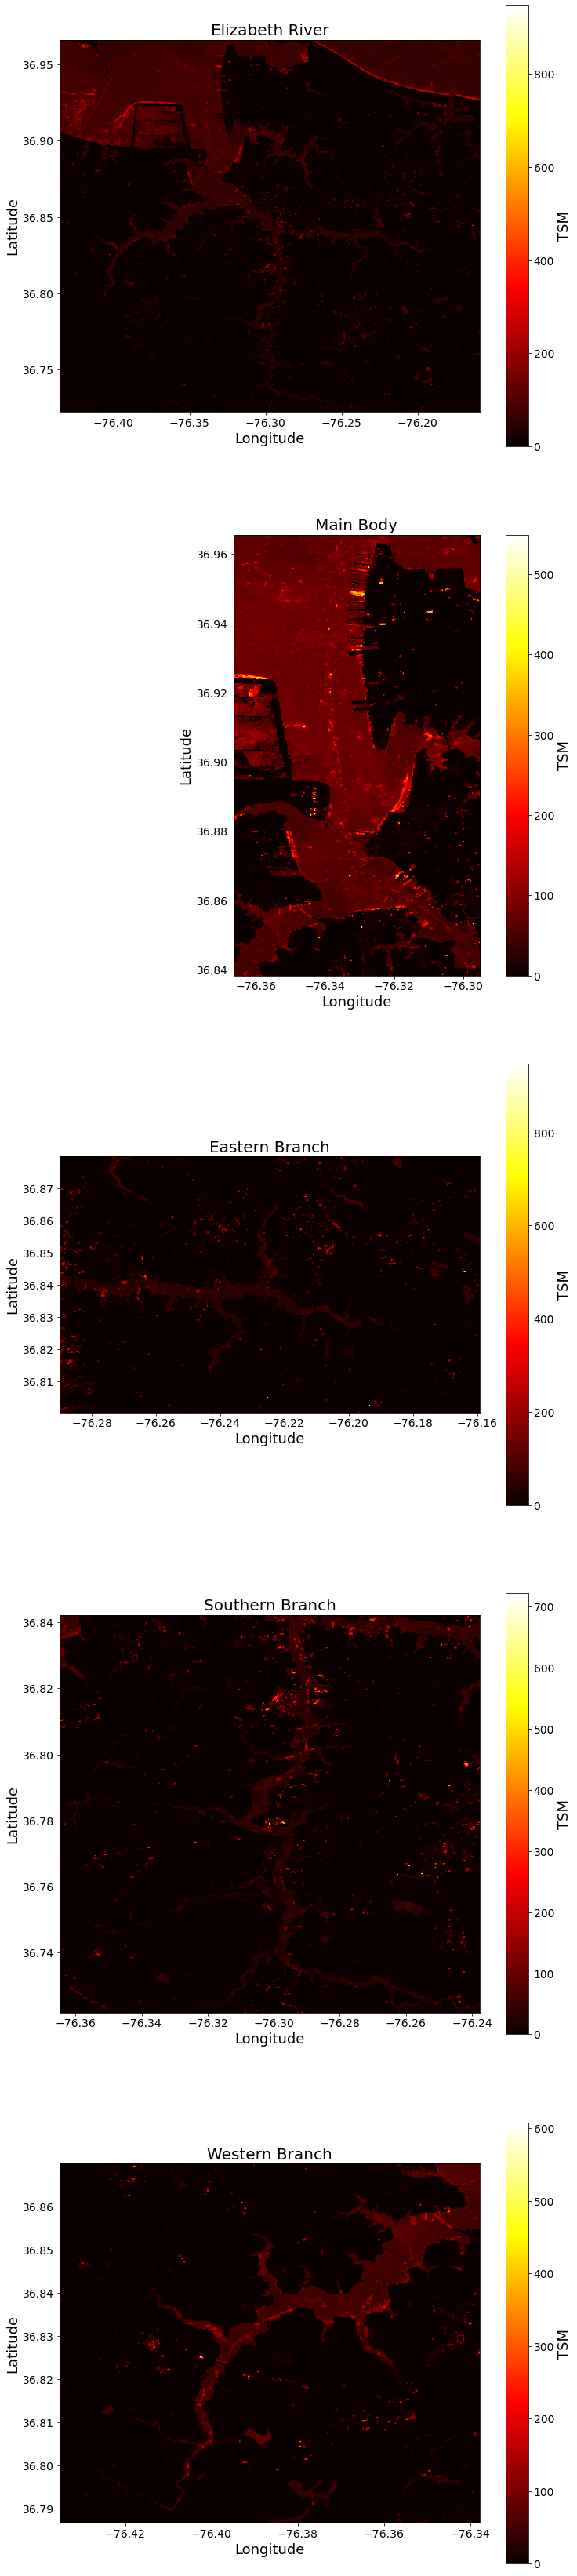

In [17]:
max_tsm_per_pixel = tsm_data.max(dim=["time"]).fillna(0)
max_tsm_per_pixel = tsm_data.max(dim=["time"]).fillna(0)
main_body_per_pixel_max = main_tsm.max(dim=["time"]).fillna(0)
east_branch_per_pixel_max = east_tsm.max(dim=["time"]).fillna(0)
south_branch_per_pixel_max = south_tsm.max(dim=["time"]).fillna(0)
west_branch_per_pixel_max = west_tsm.max(dim=["time"]).fillna(0)

fig, axes = plt.subplots(nrows=5, figsize=(12, 60))

river_sections = [max_tsm_per_pixel, 
                  main_body_per_pixel_max, 
                  east_branch_per_pixel_max, 
                  south_branch_per_pixel_max, 
                  west_branch_per_pixel_max]

for i, river_section in enumerate(river_sections):
    extent = [river_section.longitude.min(),
          river_section.longitude.max(),
          river_section.latitude.min(),
          river_section.latitude.max()]
    im = axes[i].imshow(river_section.tsm, cmap='hot', extent=extent)
    axes[i].grid(False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    tsm_scale = fig.colorbar(im, ax=axes[i])
    tsm_scale.set_label('TSM')

## Normalized Difference Vegetation Index (NDVI)

NDVI is the ratio of the difference between the amount of near infrared light (NIR) and red light (RED) divided by their sum. It is used as an indicator of vegetation and to detect changes in vegetation over time.

In the plots below, red indicates bare soil and/or highly urbanized areas, yellow indicates sparse vegetation like grasslands, and green indicates dense vegetation.

### Algorithm to Create a Riparian Buffer Mask

To focus solely on the region immediately surrounding the Elizabeth River, we present a simple algorithm for isolating the riparian zone for analysis. A riparian buffer mask is created by dilating the existing water mask by 10 pixels (300 meters) and then removing the water mask again, leaving only the 300 meter area surrounding the water.

In [18]:
from skimage.morphology import disk, dilation
water_buffer_mask = water_mask.copy()
for i in range(len(water_buffer_mask)):
    water_buffer_mask[i] = xr.DataArray(dilation(water_mask[i], disk(10)), coords=water_mask[i].coords, dims=['latitude', 'longitude'], name='wofs')
buffer_mask = xr.ufuncs.logical_xor(water_buffer_mask, water_mask)

The images below are median pixel composites of the NDVI for regions bordering selected sections of the Elizabeth River. Red indicates bare soil and/or highly urbanized areas. Yellow indicates areas of light vegetation such as grasses and bushes. Green indicates areas of dense vegetation such as trees and forests. Blues and grayscale represent the water and remaining land, respectively which are displayed for context.

This is accomplished by creating separate median pixel composites of the land, water, and NDVI for the region of interest and layering them on the same plot. 

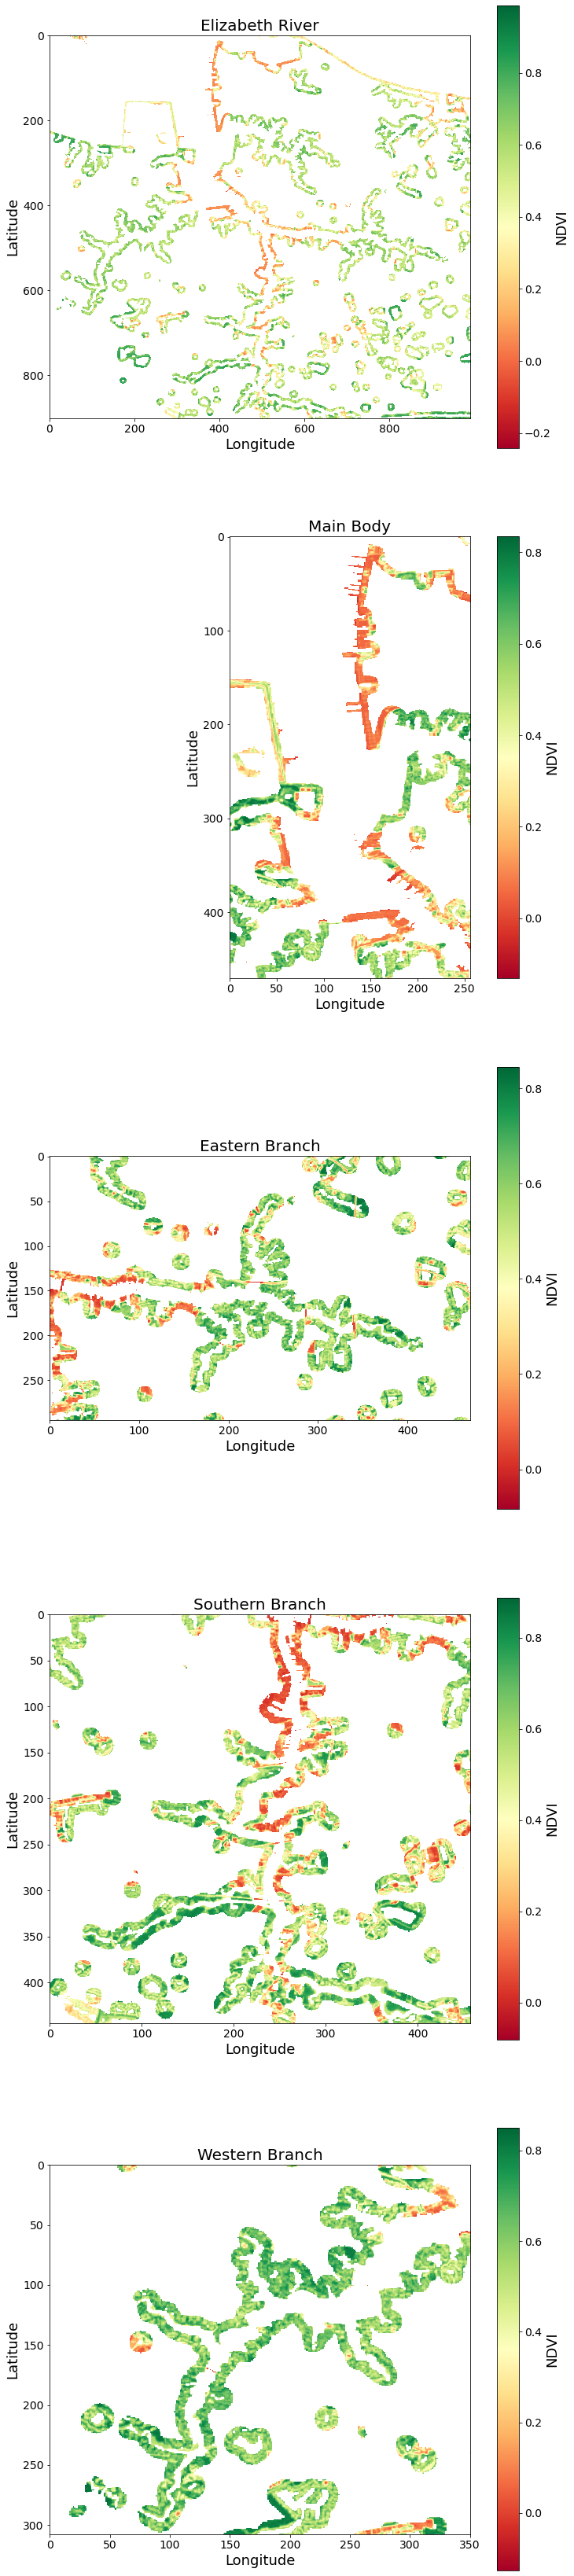

In [19]:
buffer_dataset = ls8_data.where(buffer_mask, other=-9999).astype("int16")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ndvi_composite = NDVI(create_median_mosaic(buffer_dataset, nodata=-9999))

from utils.data_cube_utilities.dc_rgb import rgb

fig, axes = plt.subplots(nrows=5, figsize=(12, 60))

elizabeth_river = dict(latitude=slice(36.9664, 36.7218), longitude=slice(-76.4351, -76.1591))

river_sections = [elizabeth_river, 
                  main_body, 
                  eastern_branch, 
                  southern_branch, 
                  western_branch]

titles = ['Elizabeth River',
          'Main Body',
          'Eastern Branch',
          'Southern Branch',
          'Western Branch']

composite_buffer_mask = buffer_mask.median(dim='time').astype('bool')
composite_buffer_mask = xr.ufuncs.logical_not(composite_buffer_mask)

land_and_water_composite = create_median_mosaic(ls8_data, no_data=-9999)

for i, river_section in enumerate(river_sections):
    river_section = river_sections[i]
    river_section_data = ndvi_composite.sel(river_sectionfro 
    extent = [river_section_data.longitude.min(),
          river_section_data.longitude.max(),
          river_section_data.latitude.min(),
          river_section_data.latitude.max()]
    river_section_mask = composite_buffer_mask.sel(river_section)
    river_section_buffers = np.ma.masked_where(river_section_mask, river_section_data)
    #rgb(land_and_water_composite.sel(river_section), bands=['nir', 'swir1', 'red'], min_possible=0, max_possible=5000, ax=axes[i])
    im = axes[i].imshow(river_section_buffers, cmap='RdYlGn')
    axes[i].grid(False)
    axes[i].set_title(titles[i])
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')
    ndvi_scale = fig.colorbar(im, ax=axes[i])
    ndvi_scale.set_label('NDVI')

The plot below shows the mean NDVI for each section of the Elizabeth River per month between 2013 and 2020.

The monthly mean was obtained by downsampling the original ~16 day day from Landsat to 1 month data. This was done to match the sample rate of the remaining water quality data.

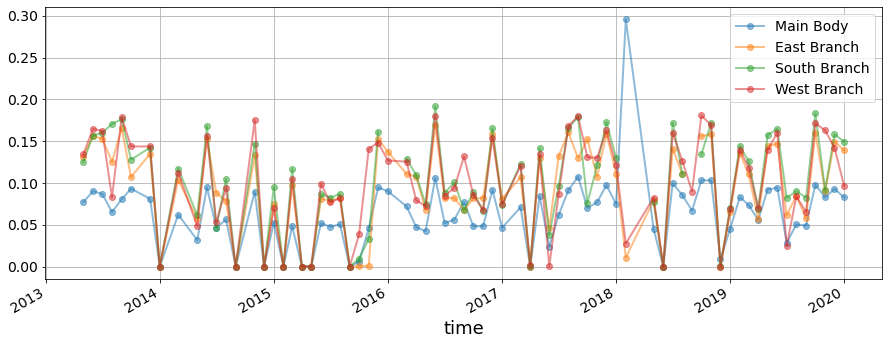

In [20]:
ndvi_data = NDVI(buffer_dataset)
main_ndvi = ndvi_data.sel(main_body)
east_ndvi = ndvi_data.sel(eastern_branch)
south_ndvi = ndvi_data.sel(southern_branch)
west_ndvi = ndvi_data.sel(western_branch)


main_body_monthly_mean_ndvi = main_ndvi.mean(dim=['latitude', 'longitude'], skipna=True).resample(time="1M") \
    .mean(skipna=True) \
    .dropna(dim='time')
east_monthly_mean_ndvi = east_ndvi.mean(dim=['latitude', 'longitude'], skipna=True).resample(time="1M") \
    .mean(skipna=True) \
    .dropna(dim='time')
south_monthly_mean_ndvi = south_ndvi.mean(dim=['latitude', 'longitude'], skipna=True).resample(time="1M") \
    .mean(skipna=True) \
    .dropna(dim='time')
west_monthly_mean_ndvi = west_ndvi.mean(dim=['latitude', 'longitude'], skipna=True).resample(time="1M") \
    .mean(skipna=True) \
    .dropna(dim='time')

fig, ax = plt.subplots(nrows=1, figsize=(15, 5))

main_body_monthly_mean_ndvi.plot(ax=ax, marker="o", alpha=0.5, label="Main Body")
east_monthly_mean_ndvi.plot(ax=ax, marker="o", alpha=0.5, label="East Branch")
south_monthly_mean_ndvi.plot(ax=ax, marker="o", alpha=0.5, label="South Branch")
west_monthly_mean_ndvi.plot(ax=ax, marker="o", alpha=0.5, label="West Branch")
ax.legend()

plt.show()

## Paradise Creek Restoration

### Mapping region of restoration project

Below, we apply the NDVI mapping algorithm to a documented riparian buffer restoration project [3] in order to verify the results of the project using LANDSAT8 data available to us. This methodology can be applied to other riparian buffer restoration projects to judge their efficacy.  

In [21]:
paradise_creek_lat_long = (36.7988, -76.3082)
paradise_creek_loc_1 = (36.796508, -76.310391)
paradise_creek_loc_2 = (36.801076, -76.306082)
paradise_creek_lat = (paradise_creek_loc_1[0], paradise_creek_loc_2[0])
paradise_creek_long = (paradise_creek_loc_1[1], paradise_creek_loc_2[1])
paradise_creek_lat_long_rect = [paradise_creek_loc_1, paradise_creek_loc_2]
m = folium.Map(location=paradise_creek_lat_long, zoom_start=16)
folium.Rectangle(bounds=paradise_creek_lat_long_rect, color='#ff7800', fill=True, fill_color='#ffff00', fill_opacity=0.2).add_to(m)
m

### Collecting Landsat 7 data of restored region

In [22]:
paradise_creek_time = ("2005-01-01", "2020-12-31")
paradise_creek_measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]
paradise_creek_ls7_data = dc.load(platform="LANDSAT_7", product="ls7_ledaps_va3414",
                                  lat=paradise_creek_lat, lon=paradise_creek_long, 
                                  time=paradise_creek_time, measurements=paradise_creek_measurements)
paradise_creek_ls7_data = paradise_creek_ls7_data.where(
                              landsat_qa_clean_mask(paradise_creek_ls7_data, "LANDSAT_7")).astype('int16')

### Getting NDVI data for restored region

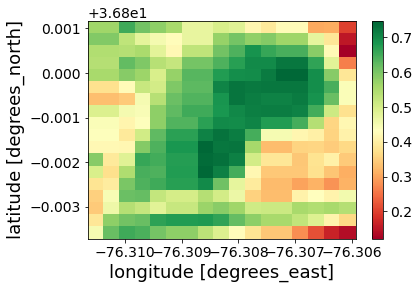

In [21]:
paradise_creek_ndvi_composite = NDVI(create_median_mosaic(paradise_creek_ls7_data)).fillna(0)
paradise_creek_ndvi_composite.plot(cmap="RdYlGn")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    paradise_creek_water_mask = wofs_classify(paradise_creek_ls7_data, no_data=0.0).wofs.astype(np.bool)
paradise_creek_land_mask = xr.ufuncs.logical_not(paradise_creek_water_mask)
paradise_creek_land_dataset = paradise_creek_ls7_data.where(paradise_creek_land_mask, other=0).astype("int16")
paradise_creek_ndvi_data = NDVI(paradise_creek_land_dataset)

### Plotting NDVI data for every month over last 15 years, decreases at beginning of project, then averages upwards 

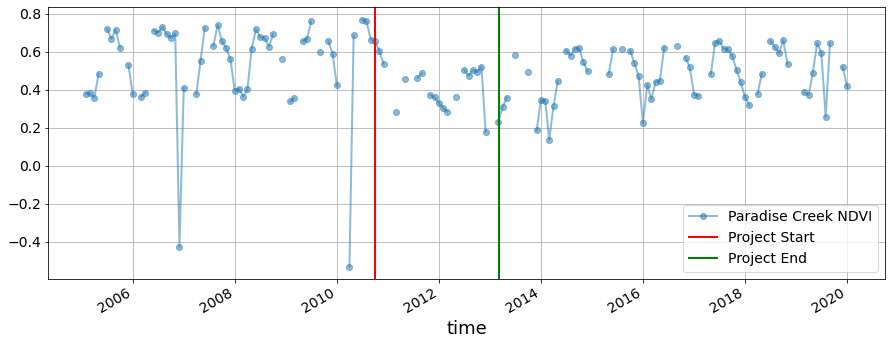

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    paradise_creek_monthly_mean_ndvi = paradise_creek_ndvi_data.mean(dim=['latitude', 'longitude']).resample(time="1M").mean()
fig, ax = plt.subplots(nrows=1, figsize=(15, 5))
paradise_creek_monthly_mean_ndvi.plot(ax=ax, marker="o", alpha=0.5, label="Paradise Creek NDVI")

ax.axvline(x='2010-09-30', color='red', label='Project Start')
ax.axvline(x='2013-03-03', color='green', label='Project End')

ax.legend()
plt.show()

It appears that the restoration project in question has not resulted in increased vegetation.  Upon closer inspection of the restoration site with higher resolution imagery, however, it appears that part of the restoration was creation of new wetland, along with walkways and a parking lot which would result in a lower NDVI value.  The NDVI value appears to have recovered in time as the plants matured.  According to the project report, the resulted in the restoration of 29 acres of mature forest and riparian buffer impacted by invasive species at Paradise Creek Nature Park [3].

# [Data Correlation Matrix &#9652;](#Index)
---
In order to explore correlations in the water quality, optical density, and Landsat 8 data, the data structures were converted and appended to a time series data structure and resampled to a weekly cadence using the mean. Although most of the data has a monthly cadence, the weekly cadence provides greater resolution when available without oversampling.

In [23]:
dim = ["latitude", "longitude"]
ts_data = eliz_data.set_index("time").drop(columns=["station", "lat", "lon", "depth"])
ts_data = ts_data[ts_data.index.year >= 2013]
od_ts_data = eliz_od_data.set_index("time").drop(columns=["station", "lat", "lon", "od_645b", "od_663b"])
od_ts_data = od_ts_data[od_ts_data.index.year >= 2013]
ts_data = ts_data.join(od_ts_data, how="outer")
ts_data = ts_data.join(tsm_data.max(dim=dim).fillna(0).to_dataframe().rename(columns={"tsm": "TSM_max"}), how="outer")
ts_data = ts_data.join(tsm_data.mean(dim=dim).fillna(0).to_dataframe().rename(columns={"tsm": "TSM_mean"}), how="outer")
ts_data = ts_data.join(ndvi_data.mean(dim=dim).fillna(0).to_dataframe(name="NDVI_mean"), how="outer")

The Pearson correlation is then computed across all pairs of variables as depicted below. The [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) indicates the linear correlation as a number between -1 (negatively correlated) to 0 (not correlated) to 1 (positively correlated). The darker the color, the stronger the correlation. The Pearson measures global correlation and does not provide information about phasing or directionality between the two variables.

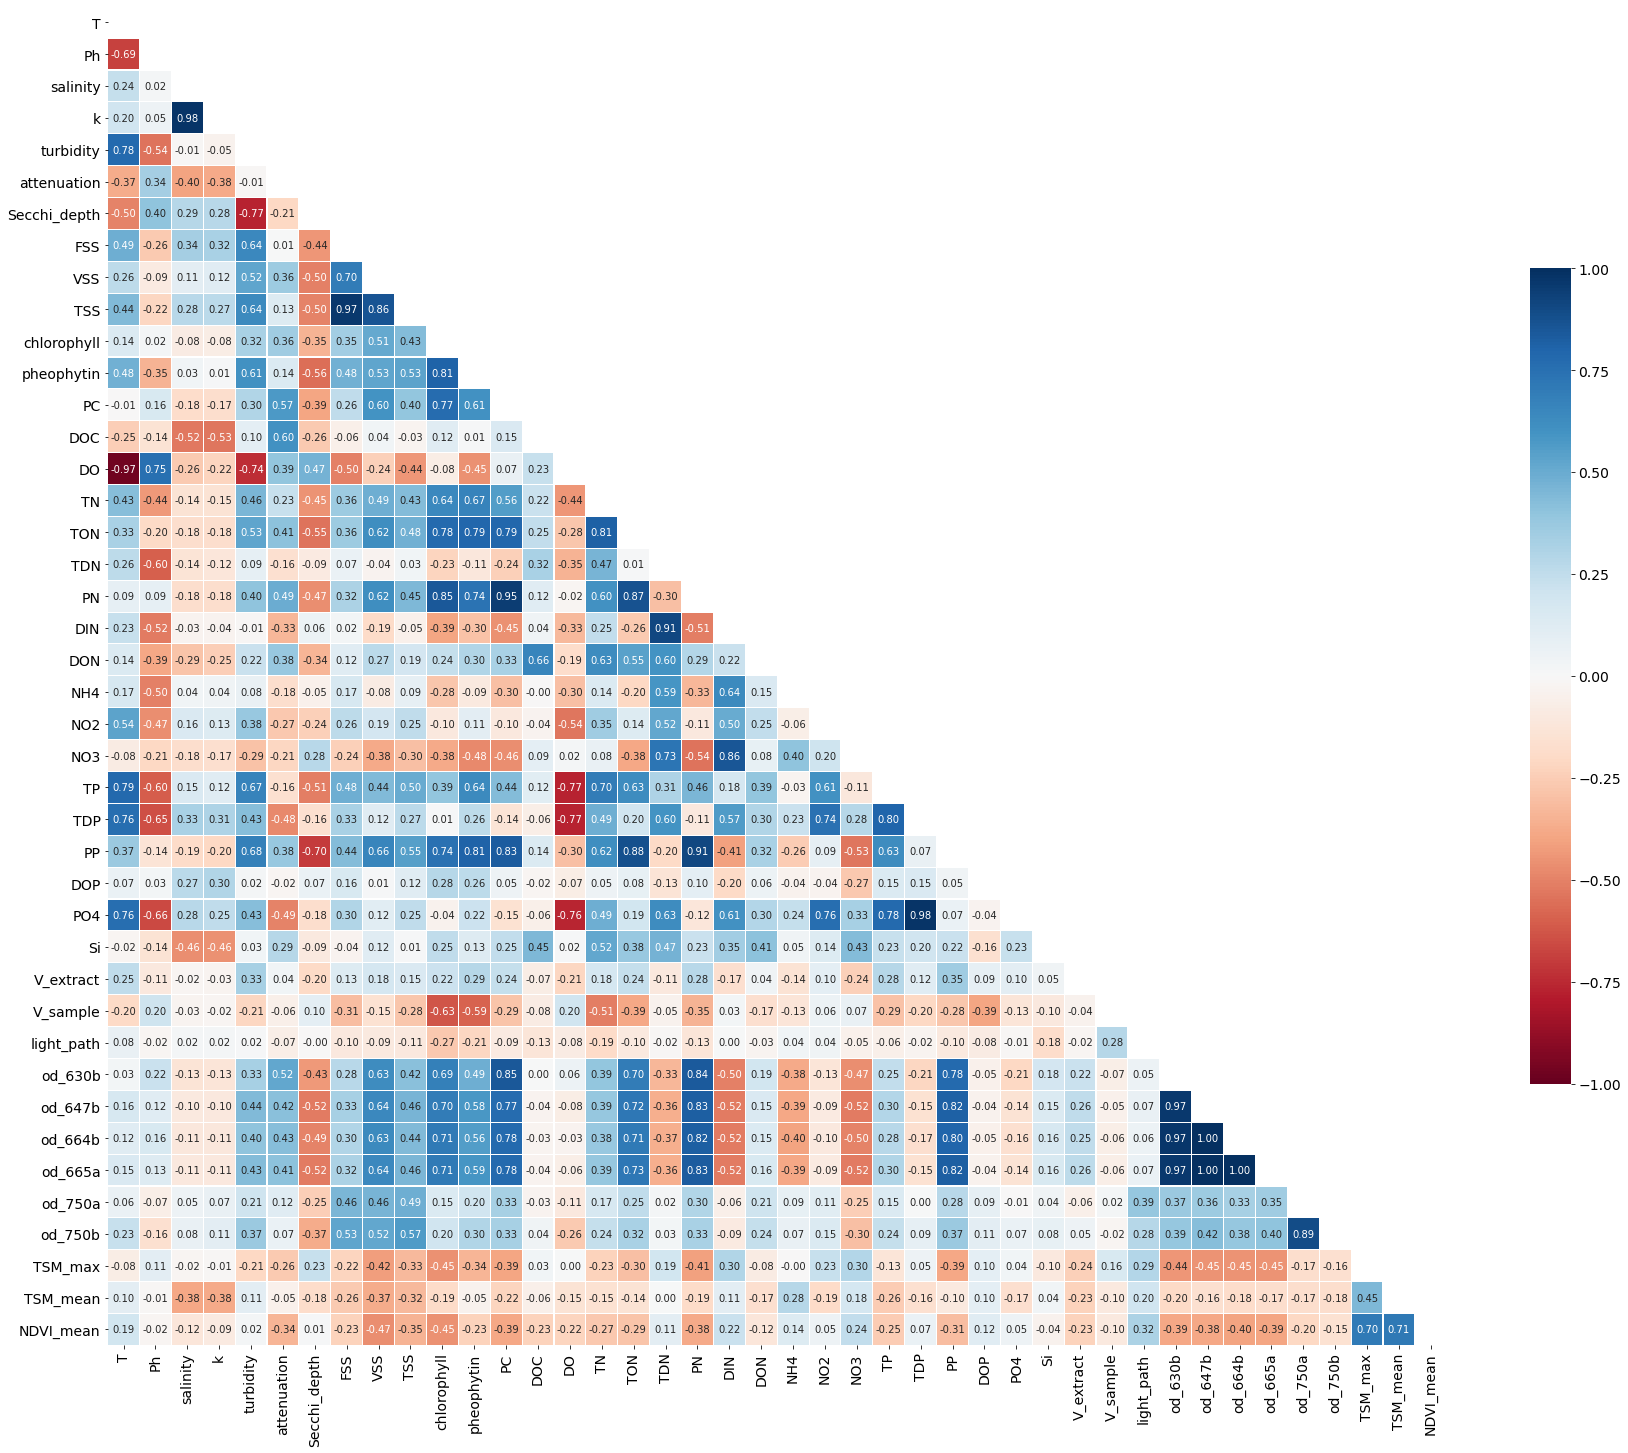

In [24]:
corr = ts_data.resample("W").mean().corr()
mask = np.full(corr.shape, False, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(30,30))
hmap = sns.heatmap(corr, mask=mask, cmap=plt.cm.RdBu, vmax=1, vmin=-1, square=True,
                   linewidths=0.1, linecolor='white', annot=True, fmt=".2f", cbar_kws={"shrink": 0.5})

### List of Strong Correlations
From the matrix visualization above we create a list of the strongest correlations. Later, we graph a few of these correlations to gain better insight.

In [25]:
corr[(corr.abs() > 0.75) & (~mask)].stack().sort_values()

DO            T             -0.969748
TP            DO            -0.773149
TDP           DO            -0.770694
Secchi_depth  turbidity     -0.767626
PO4           DO            -0.764828
DO            Ph             0.754691
PO4           NO2            0.758534
              T              0.760157
TDP           T              0.764810
PC            chlorophyll    0.766088
od_647b       PC             0.772877
od_664b       PC             0.775235
od_665a       PC             0.776909
turbidity     T              0.777366
PO4           TP             0.777389
od_630b       PP             0.777723
TON           chlorophyll    0.777912
TP            T              0.786929
TON           PC             0.790025
              pheophytin     0.790206
TDP           TP             0.802413
od_664b       PP             0.804568
pheophytin    chlorophyll    0.806944
PP            pheophytin     0.808952
TON           TN             0.813592
od_647b       PP             0.817259
od_665a     

## Time-Lagged Cross-Correlation

Time-lagged cross correlation was performed on chlorophyll, dissolved oxygen, phosphate, and nitrate in order to understand the phasing or directionality between the variables. Unfortunately, the limited resolution of the water quality data means the phasing offset is a month.  Ideally, we would like this time to be shorter.

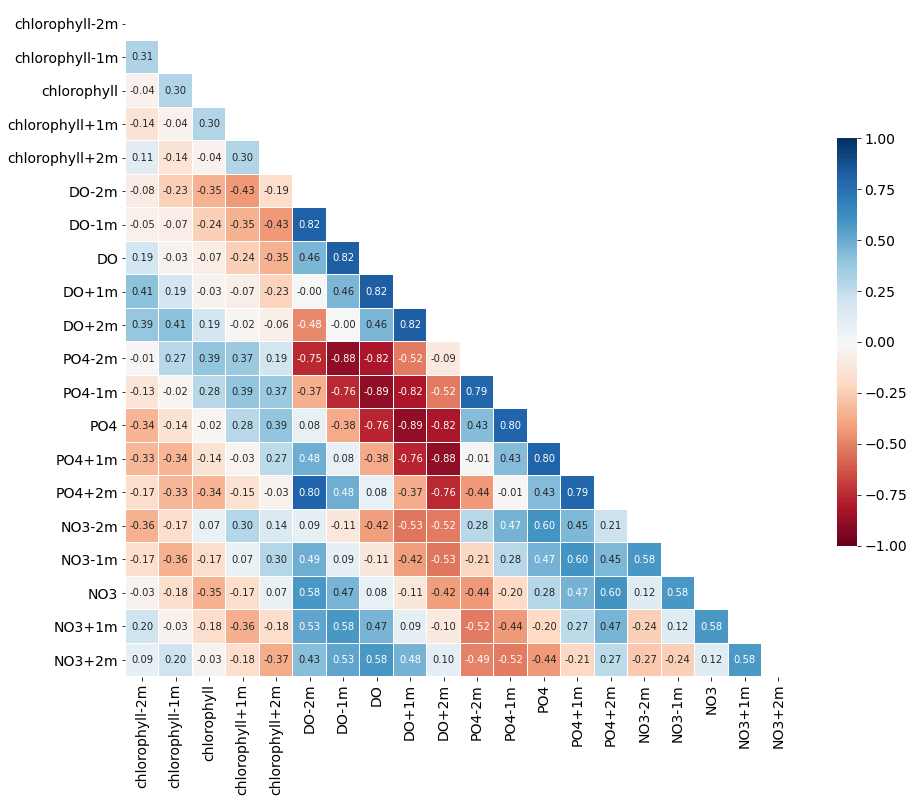

In [26]:
tlcc = ts_data[["chlorophyll", "DO", "PO4", "NO3"]].resample("M").mean()
cols = []
for col in tlcc.columns:
    for i in range(-2, 3):
        s = col if i == 0 else "%s%+dm" % (col, i)
        cols.append(s)
        tlcc[s] = tlcc[col].shift(periods=i)
tlcc = tlcc.reindex(cols, axis=1)
corr = tlcc.corr()
mask = np.full(corr.shape, False, dtype=bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(15,15))
hmap = sns.heatmap(corr, mask=mask, cmap=plt.cm.RdBu, vmax=1, vmin=-1, square=True,
                   linewidths=0.1, linecolor='white', annot=True, fmt=".2f", cbar_kws={"shrink": 0.5})

Of interest is that there appears to be a stronger correlation between current phosphate levels and dissolved oxygen levels one month later, meaning that an increase in phosphate levels is followed by a decrease in oxygen a month later.  While this does not necessarily prove a cause and effect relationship, it suggests that there may be one.  

# [Data Plots &#9652;](#Index)
---
## Dissolved Oxygen and Phosphates

Dissolved oxygen is a measure of the amount of oxygen dissolved in the water and available to aquatic life. Dissolved oxygen is inversely correlated with water temperature since as water warms it cannot physically hold as much oxygen. We have observed that dissolved oxygen is also inversely correlated with phosphate levels.

Phosphate (PO4) , similar to fixed nitrogen, is a critical nutrient for life as it is necessary for the transport of energy, formation of DNA, and the creation of cellular membranes. However, too much phosphate can disrupt aquatic ecosystems: Phosphate is normally considered the limiting factor for algal growth. An influx of phosphate can trigger a bloom in already nutrient-rich water.

One hypothesis is that these two values are inversely correlated due to the activity of algae. Discharged nutrients, such as nitrogen and phosphorous, can stimulate an algal bloom. When the algae comprising the blooms die off, there is then a depletion of oxygen as they are degraded by bacteria, causing the formation of a dead zone. When oxygen concentrations drop below 8 mg/L the water is considered hypoxic and part of a dead zone.   Organisms which require oxygen (such as fish and other animals) may die if unable to escape to more oxygen-rich areas.  This phenomenon is known as [eutrophication](https://en.wikipedia.org/wiki/Eutrophication).

Below, we plot both phosphate (PO40 and Dissolved Oxygen (DO) vs. time using data parsed from non-GIS sources:


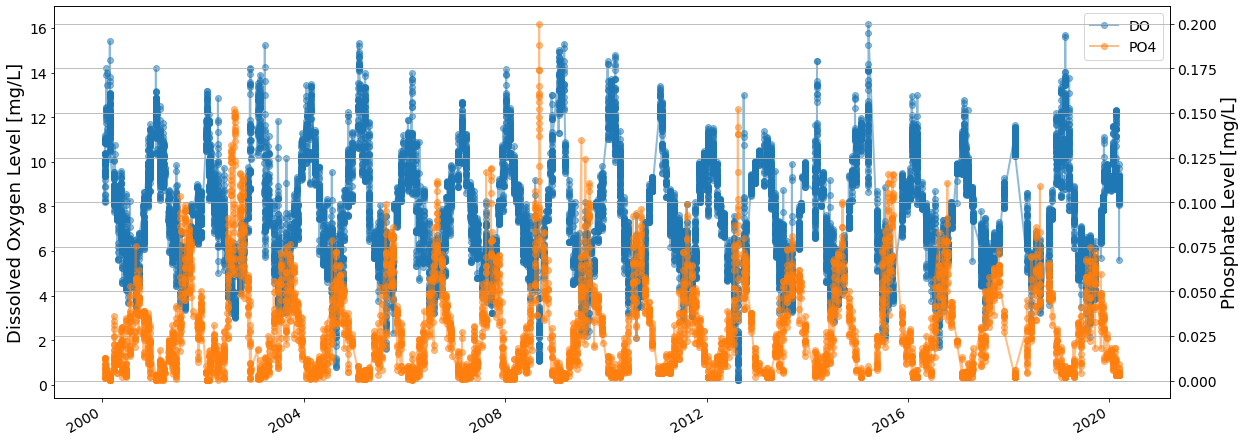

In [27]:
fig, ax = plt.subplots(figsize=(20, 8))
ax1 = eliz_data.set_index("time")["DO"].dropna().plot(ax=ax, marker="o", alpha=0.5)
ax2 = eliz_data.set_index("time")["PO4"].dropna().plot(ax=ax, secondary_y=True, marker="o", alpha=0.5)
# Monthly Avg
#ax1 = eliz_data.set_index("time")["DO"].resample("M").mean().dropna().plot(ax=ax, marker="o", alpha=0.5)
#ax2 = eliz_data.set_index("time")["PO4"].resample("M").mean().dropna().plot(ax=ax, secondary_y=True, marker="o", alpha=0.5)
# Weekly Avg
#ax1 = eliz_data.set_index("time")["DO"].resample("W").mean().dropna().plot(ax=ax, marker="o", alpha=0.5)
#ax2 = eliz_data.set_index("time")["PO4"].resample("W").mean().dropna().plot(ax=ax, secondary_y=True, marker="o", alpha=0.5)
ax.set_xlabel("")
ax1.set_ylabel("Dissolved Oxygen Level [%s]" % descrip.loc["DO", "units"])
ax2.set_ylabel("Phosphate Level [%s]" % descrip.loc["PO4", "units"])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1+lines2, labels1+labels2)
plt.show()


In [28]:
#This helper function simplifies plotting for multiple branches of the river
def plot_branches(ax, var, data):
    cond = (data["depth"] == 1) if var == "T" else True
    data[(data["station"].isin(ne_stations)) & cond].set_index("time")[var].dropna(
        ).plot(ax=ax, marker="o", alpha=0.5, label="Northeast Branch")
    data[(data["station"].isin(east_stations)) & cond].set_index("time")[var].dropna(
        ).plot(ax=ax, marker="o", alpha=0.5, label="East Branch")
    data[(data["station"].isin(west_stations)) & cond].set_index("time")[var].dropna(
        ).plot(ax=ax, marker="o", alpha=0.5, label="West Branch")
    data[(data["station"].isin(south_stations)) & cond].set_index("time")[var].dropna(
        ).plot(ax=ax, marker="o", alpha=0.5, label="South Branch")
    data[(data["station"].isin(main_stations)) & cond].set_index("time")[var].dropna(
        ).plot(ax=ax, marker="o", alpha=0.5, label="Main Branch")
    ax.set_xlabel("")
    ax.legend()

### Temperature

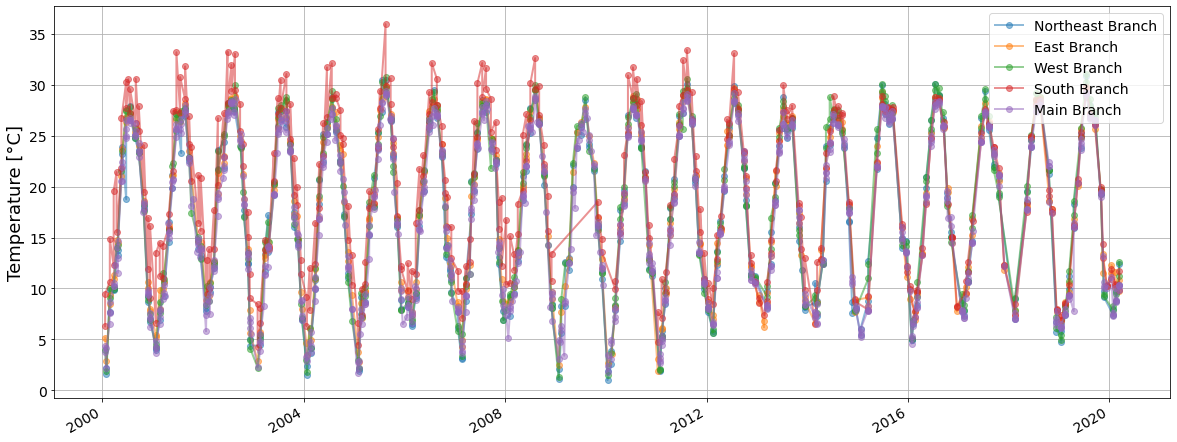

In [29]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_branches(ax, "T", data)
ax.set_ylabel("Temperature [%s]" % descrip.loc["T", "units"])
plt.show()

### Filtered Nitrates, Total Dissolved Phosphorus, and Total Suspended Solids

As suggested by [Lowrance [1997]](https://link.springer.com/content/pdf/10.1007/s002679900060.pdf), buffer health is indicated by the removal of nitrate, sediment, and dissolved phosphorus. 

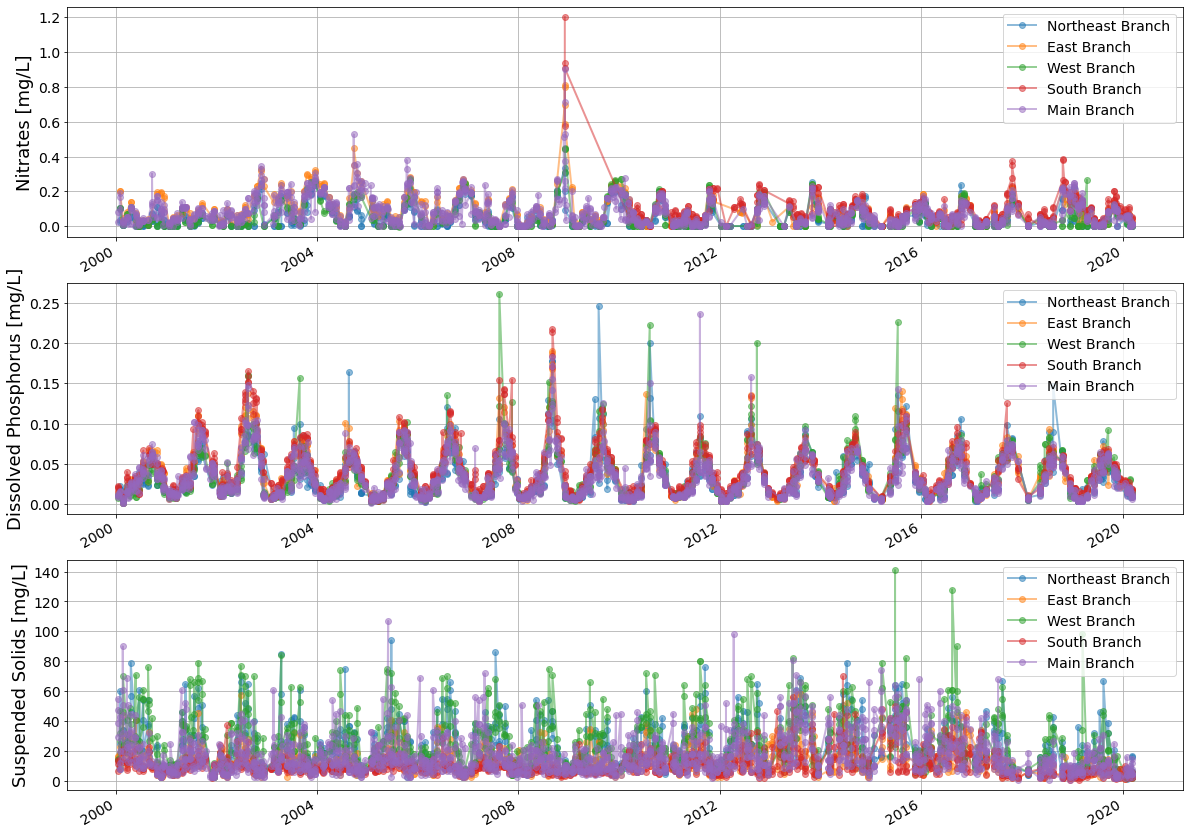

In [30]:
fig, ax = plt.subplots(nrows=3, figsize=(20, 16))
plot_branches(ax[0], "NO3", data)
plot_branches(ax[1], "TDP", data)
plot_branches(ax[2], "TSS", data)
#ax[0].set_yscale("log"), ax[1].set_yscale("log"), ax[2].set_yscale("log")
ax[0].set_ylabel("Nitrates [%s]" % descrip.loc["NO3", "units"])
ax[1].set_ylabel("Dissolved Phosphorus [%s]" % descrip.loc["TDP", "units"])
ax[2].set_ylabel("Suspended Solids [%s]" % descrip.loc["TSS", "units"])
plt.show()

### Optical Density

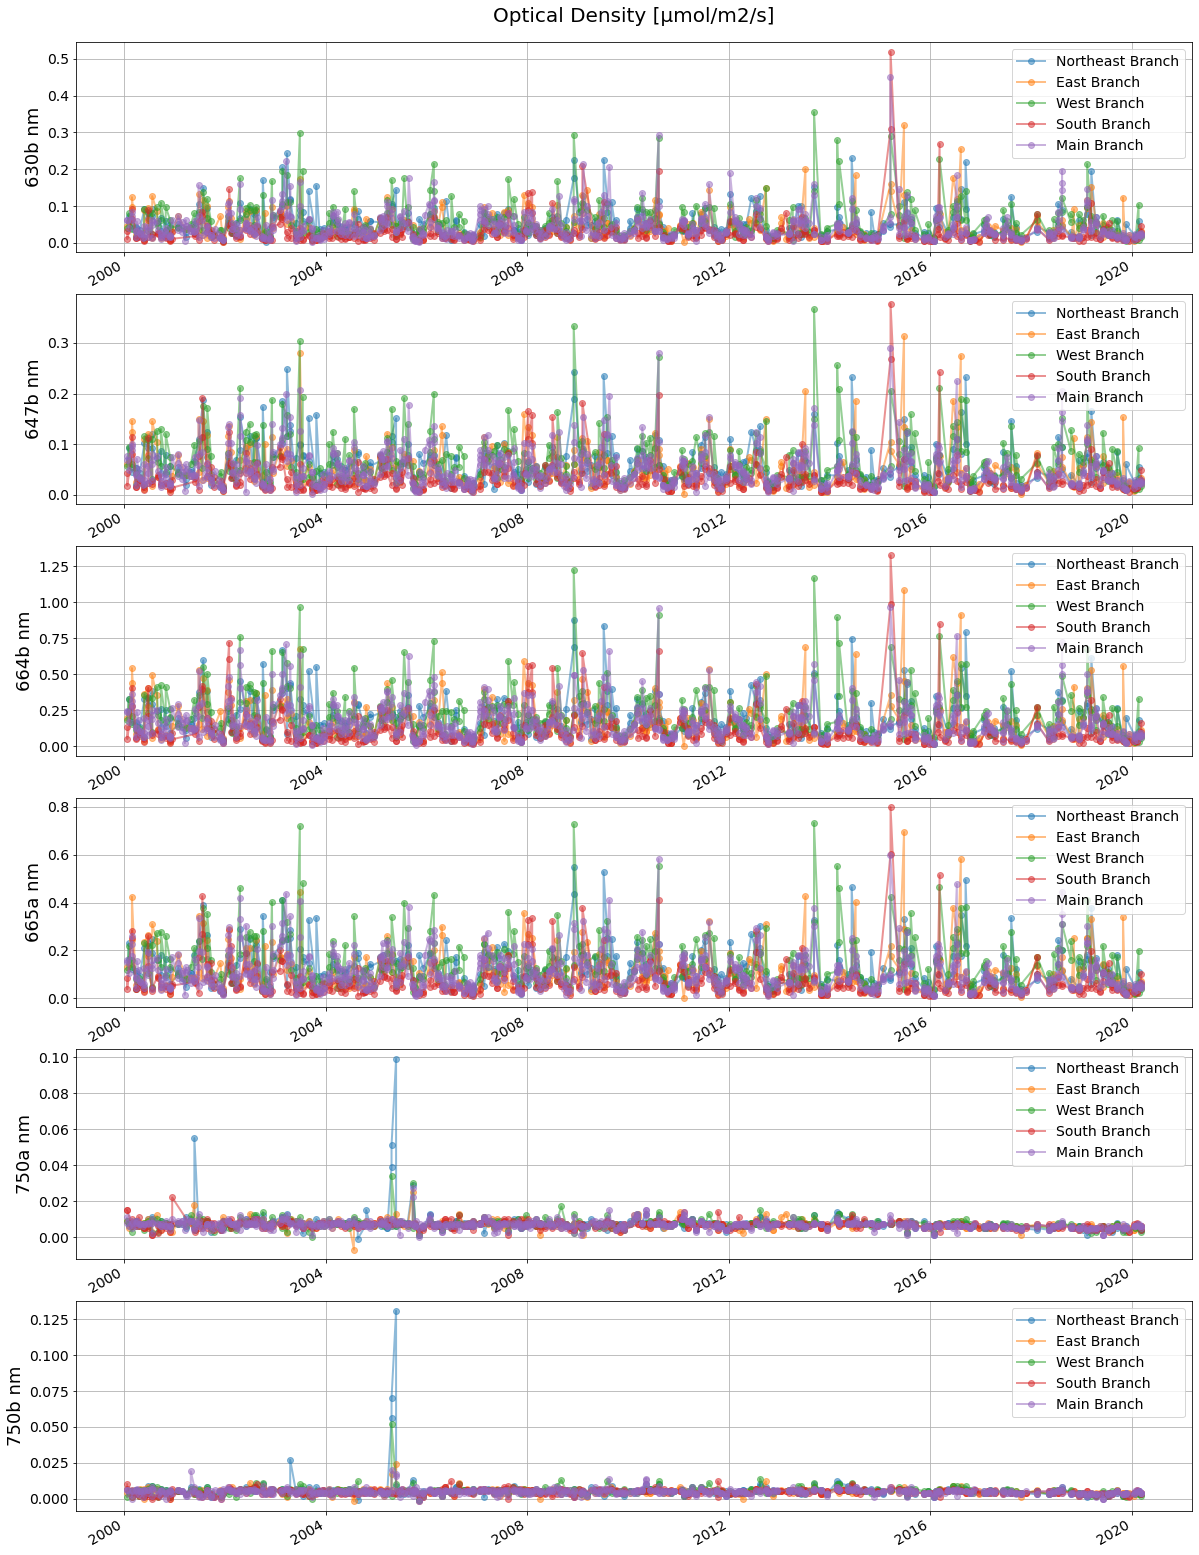

In [31]:
od_vars = sorted([s for s in od_descrip.index if s.startswith("od")])
od_vars.remove("od_645b")
od_vars.remove("od_663b")
fig, ax = plt.subplots(nrows=len(od_vars), figsize=(20, 30))
for i, od in enumerate(od_vars):
    plot_branches(ax[i], od, od_data)
    ax[i].set_ylabel("%s nm" % od[-4:])
ax[0].set_title("Optical Density [%s]" % od_descrip.loc[od, "units"], pad=20)
plt.show()

## [Conclusion and Future Work &#9652;](#Index)
---
We have demonstrated how to integrate GIS and non-GIS data sources to investigate potential ecological and water quality correlations.  We have also presented an algorithm for identifying riparian buffer regions from satellite data and calculating an NDVI index for them.  We have observed and identified a potential relationship of interest between Dissolved Oxygen and Phosphates which could be a target of future investigations of remote sensing with Landsat or other satellite imagery. Other areas for future work include:

* Investigating riparian buffers over larger or longer spatiotemporal scales

* An immediate area of exploration could also be to tease out year-over-year trends from the seasonal variation 

* Another area of future exploration is land cover classification and quantifying the areas of effective buffer from satellite imagery ![Riparian Buffer classification](imgs/riparian_classification.png)

Image from Klemas 2014 [4]


The figure below is a false color composite of three separate images created from Landsat 8 data and Data Cube algorithms.

The background image is a median mosaic of Landsat 8 bands nir, swir 1, and red which have been mapped to red, green, and blue respectively. This type of false color image is good for distinguishing land from water.

On top of the background image is the per pixel mean NDVI for the buffer region surrounding the Elizabeth River.

The final image is the per pixel mean TSM for the Elizabeth River plotted using the 'cool' color map to avoid confusion with the NDVI which also contains red.

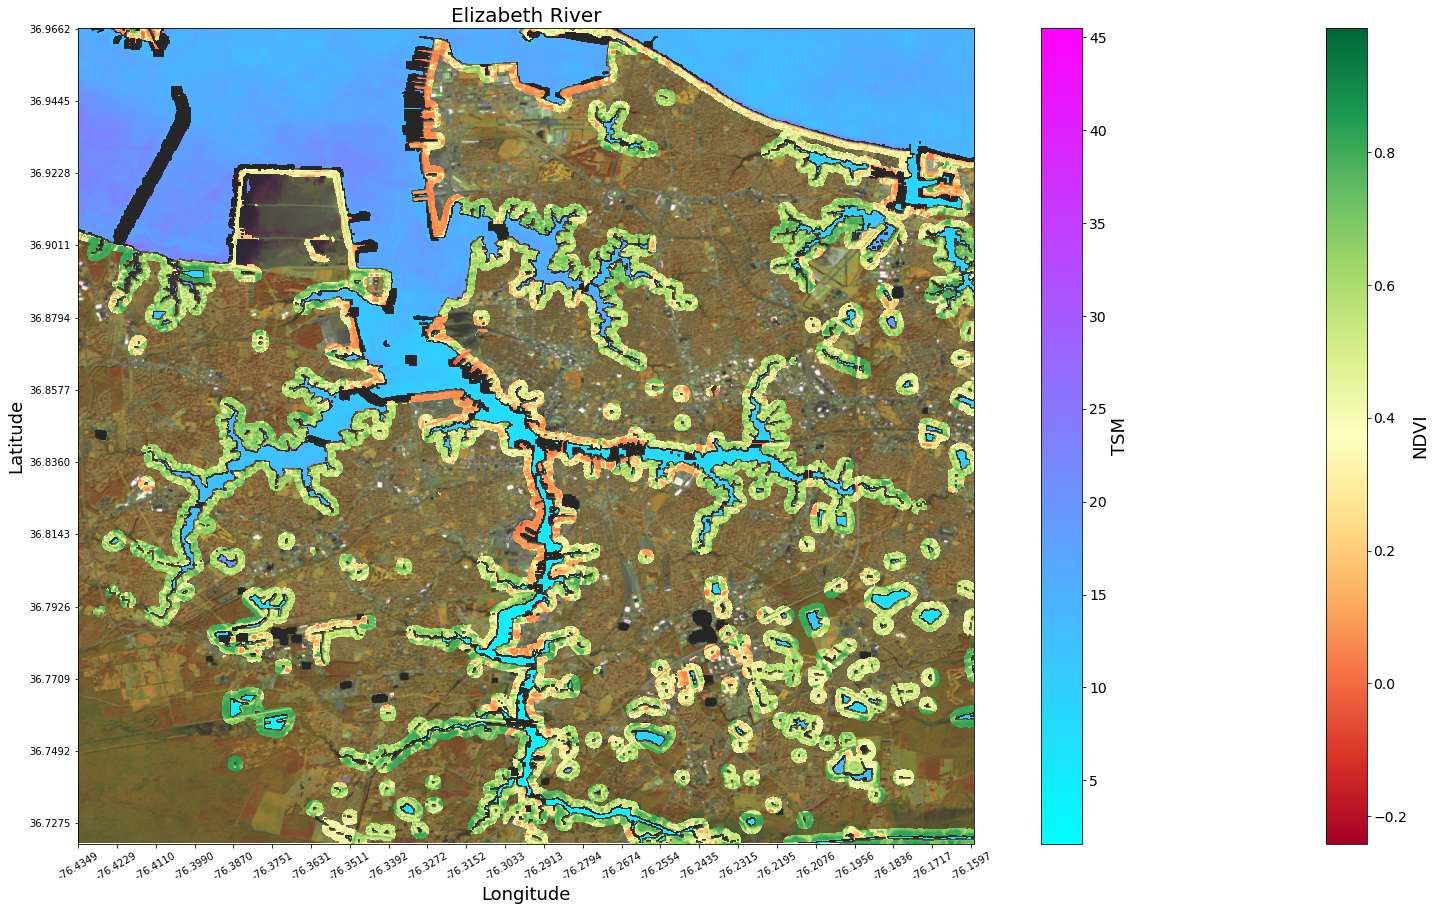

In [32]:
fig, ax = plt.subplots(nrows=1, figsize=(30, 15))

ndvi_composite
extent = [ndvi_composite.longitude.min(),
      ndvi_composite.longitude.max(),
      ndvi_composite.latitude.min(),
      ndvi_composite.latitude.max()]
elizabeth_river_buffers = np.ma.masked_where(composite_buffer_mask, ndvi_composite)
+(land_and_water_composite.sel(elizabeth_river), bands=['nir', 'swir1', 'red'], min_possible=0, max_possible=5000, ax=ax)
im = ax.imshow(elizabeth_river_buffers, cmap='RdYlGn')
ndvi_scale = fig.colorbar(im, ax=ax)
ndvi_scale.set_label('NDVI')
land_mask = xr.ufuncs.logical_not(water_mask)
composite_land_mask = land_mask.median(dim='time').astype('bool')
elizabeth_river_tsm = np.ma.masked_where(composite_land_mask, mean_tsm_per_pixel.tsm)
im = ax.imshow(elizabeth_river_tsm, cmap='cool')
ax.grid(False)
ax.set_title('Elizabeth River')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
tsm_scale = fig.colorbar(im, ax=ax)
tsm_scale.set_label('TSM')

The image above represents is a composite of all our GIS based analyses.  The water portion of the image represents Total Suspended Matter (TSM) with purple areas indicating higher amounts of suspended matter sensed from GIS observations.  The green and red areas along the river represent riparian vegetation, with green areas representing plant life.

## [References &#9652;](#Index)
---
[1] Cunningham, Kyle, et al. Riparian Buffers: Types and  Establishment Methods. p. 6.
(Cunningham, Stuhlinger, and Liechty, n.d.)

[2] Lowrance, Richard, et al. “Water Quality Functions of Riparian Forest Buffers in Chesapeake Bay Watersheds.” Environmental Management, vol. 21, no. 5, Sept. 1997, pp. 687–712. Crossref, doi:10.1007/s002679900060.

[3] The Elizabeth River Project, Paradise Creek Riparian Buffer Restoration (VA) Final Report.  March 2013.  Available https://www.nfwf.org/sites/default/files/finalreports1/24395_Final_Report.pdf Retrieved 8/28/2020

[4] Klemas, V. (2014). Remote sensing of riparian and wetland buffers: an overview. Journal of Coastal Research, 30(5), 869-880.

Prepared by Analytical Mechanics Associates for VMASC